In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

In [2]:
print(tf.__version__)
print(tf.test.is_gpu_available())
print(tf.test.is_built_with_cuda())

2.1.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True
True


In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"   
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)#动态分配gpu别让tf一下占满

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


构建模型（顺序模型、函数式模型、子类模型）
模型训练：model.fit()
模型验证：model.evaluate()
模型预测： model.predict()
提供许多内置的优化器，损失和指标 通常，不必从头开始创建自己的损失，指标或优化函数，因为所需的可能已经是Keras API的一部分：

优化器：

SGD() （有或没有动量）
RMSprop()
Adam()
损失：

MeanSquaredError()
KLDivergence()
CosineSimilarity()
指标：

AUC()
Precision()
Recall()
另外，如果想用上述的默认设置，那么在很多情况下，可以通过字符串标识符指定优化器，损失和指标：

先写个自定义的层连连手

In [4]:
class MyLinear(layers.Layer):
    def __init__(self,units = 64):
        super(MyLinear,self).__init__()
        self.units = units
        
    def build(self,input_shape):
        self.w = self.add_weight(shape=(input_shape[-1],self.units), 
                                 initializer = 'random_normal',
                                 trainable = True,
                                 name = 'w')
        self.b = self.add_weight(shape =(self.units,),
                                 initializer ='random_normal',
                                 trainable = True,
                                 name = 'b')
        
    def call(self,inputs):
        x = tf.matmul(inputs,self.w) + self.b
        x = tf.keras.activations.relu(x,alpha = 0.0)
        return x

接下来模型子类化

In [5]:
class MyModel (tf.keras.Model):
    def __init__(self,num_class = 10):
        super(MyModel,self).__init__()
        self.num_class = num_class
        self.dense_1 = MyLinear(64)#看看和直接调用的Dense一不一样
        self.dense_2 = layers.Dense(64,activation='relu')
        self.dense_3 = layers.Dense(num_class)
    
    def call(self,inputs):
        x = self.dense_1(inputs)
        x = self.dense_2(x)
        pre = self.dense_3(x)
        return pre

In [6]:
input1 = tf.keras.Input(shape=(32,))
my_model  = MyModel(10)
my_model.build(input1.shape)
my_model.call(input1)
my_model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
my_linear (MyLinear)         (None, 64)                2112      
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 6,922
Trainable params: 6,922
Non-trainable params: 0
_________________________________________________________________


In [7]:
adam = tf.keras.optimizers.Adam(lr = 0.001,beta_1= 0.9, beta_2=0.999, epsilon=None,decay = 0.0, amsgrad = False)
sc = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
acc = tf.keras.metrics.Accuracy()
my_model.compile(optimizer= adam, loss = sc,metrics=['accuracy'])#注意metrics这项要用中括号 自定义也是一样

接下来弄一下数据

In [8]:
X_train = np.random.random((1000, 32))
Y_train = np.random.randint(10, size=(1000, ))

X_val = np.random.random((200, 32))
Y_val = np.random.randint(10, size=(200, ))

X_test = np.random.random((200, 32))
Y_test = np.random.randint(10, size=(200, ))

In [9]:
my_model.fit(X_train, Y_train, batch_size=64, epochs=5, validation_data=  (X_val, Y_val))

Train on 1000 samples, validate on 200 samples
Epoch 1/5
1000/1000 [==============================] - 0s 431us/sample - loss: 2.3019 - accuracy: 0.1000 - val_loss: 2.3094 - val_accuracy: 0.0750
Epoch 2/5
1000/1000 [==============================] - 0s 26us/sample - loss: 2.2897 - accuracy: 0.1270 - val_loss: 2.3117 - val_accuracy: 0.0950
Epoch 3/5
1000/1000 [==============================] - 0s 26us/sample - loss: 2.2819 - accuracy: 0.1320 - val_loss: 2.3186 - val_accuracy: 0.0950
Epoch 4/5
1000/1000 [==============================] - 0s 26us/sample - loss: 2.2780 - accuracy: 0.1320 - val_loss: 2.3137 - val_accuracy: 0.0800
Epoch 5/5
1000/1000 [==============================] - 0s 29us/sample - loss: 2.2728 - accuracy: 0.1380 - val_loss: 2.3196 - val_accuracy: 0.1000


模型验证

In [10]:
print('\n# Evaluate on test data')
results = my_model.evaluate(X_test, Y_test, batch_size=128)#输出模型预测在test数据上的loss acc
print('test loss, test acc:', results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print('\n# Generate predictions for 3 samples')
predictions = my_model.predict(X_test[:3])
print('predictions shape:', predictions.shape)


# Evaluate on test data
200/200 [==============================] - 0s 218us/sample - loss: 2.3238 - accuracy: 0.0800
test loss, test acc: [2.323764123916626, 0.08]

# Generate predictions for 3 samples
predictions shape: (3, 10)


样本加权 就比如上次那个草津气温有的统计的不好缺失等等，虽然补全了可是依然不太希望用，样本加权场景满多的

In [11]:
sample_weight = np.ones(shape =(len(Y_train),))
print(sample_weight.shape,sample_weight.dtype)
print(sample_weight[:100])
print([Y_train==5])
sample_weight[Y_train==5] = 2.#这一步很巧Y_train = 5这个切片正好拿来用
print(sample_weight[:100])

(1000,) float64
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1.]
[array([False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False,  True,
       False, False, False, False,  True, False, False, False, False,
       False, False,  True, False,  True, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False,  True, False, False,  True, False, False, False,
       False, False, False, False, False, False

In [12]:
my_model.fit(X_train,Y_train,sample_weight = sample_weight,batch_size = 64,epochs =4)

  ...
    to  
  ['...']
Train on 1000 samples
Epoch 1/4
1000/1000 [==============================] - 0s 254us/sample - loss: 2.4780 - accuracy: 0.1220
Epoch 2/4
1000/1000 [==============================] - 0s 28us/sample - loss: 2.4638 - accuracy: 0.1050
Epoch 3/4
1000/1000 [==============================] - 0s 21us/sample - loss: 2.4491 - accuracy: 0.1170
Epoch 4/4
1000/1000 [==============================] - 0s 24us/sample - loss: 2.4402 - accuracy: 0.1120


模型加权

In [13]:
class_weight = {0: 1., 1: 1., 2: 1., 3: 1., 4: 1.,
                5: 2.,
                6: 1., 7: 1., 8: 1., 9: 1.}
my_model.fit(X_train,Y_train,sample_weight = sample_weight,class_weight= class_weight,batch_size = 64,epochs =4)

  ...
    to  
  ['...']
Train on 1000 samples
Epoch 1/4
1000/1000 [==============================] - 0s 24us/sample - loss: 2.7277 - accuracy: 0.1060
Epoch 2/4
1000/1000 [==============================] - 0s 20us/sample - loss: 2.6989 - accuracy: 0.1010
Epoch 3/4
1000/1000 [==============================] - 0s 22us/sample - loss: 2.6871 - accuracy: 0.1040
Epoch 4/4
1000/1000 [==============================] - 0s 21us/sample - loss: 2.6711 - accuracy: 0.1070


使用回调函数
Keras中的回调是在训练期间（在某个时期开始时，在批处理结束时，在某个时期结束时等）在不同时间点调用的对象，这些对象可用于实现以下行为：

在训练过程中的不同时间点进行验证（除了内置的按时间段验证）

定期或在超过特定精度阈值时对模型进行检查

当训练似乎停滞不前时，更改模型的学习率

当训练似乎停滞不前时，对顶层进行微调

在训练结束或超出特定性能阈值时发送电子邮件或即时消息通知 等等。 回调可以作为列表传递给model.fit：
许多内置的回调可用
ModelCheckpoint：定期保存模型。
EarlyStopping：当培训不再改善验证指标时，停止培训。
TensorBoard：定期编写可在TensorBoard中可视化的模型日志（更多详细信息，请参见“可视化”部分）。
CSVLogger：将损失和指标数据流式传输到CSV文件。 等等

3.1 EarlyStopping(早停)
monitor: 被监测的数据。
min_delta: 在被监测的数据中被认为是提升的最小变化， 例如，小于 min_delta 的绝对变化会被认为没有提升。
patience: 没有进步的训练轮数，在这之后训练就会被停止。
verbose: 详细信息模式。
mode: {auto, min, max} 其中之一。 在 min 模式中， 当被监测的数据停止下降，训练就会停止；在 max 模式中，当被监测的数据停止上升，训练就会停止；在 auto 模式中，方向会自动从被监测的数据的名字中判断出来。

In [14]:
tf.keras.callbacks.EarlyStopping?

In [15]:
def get_compiled_model():
    model = MyModel(10)
    adam = tf.keras.optimizers.Adam(lr = 0.001,beta_1= 0.9, beta_2=0.999, epsilon=None,decay = 0.0, amsgrad = False)
    sc = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer= adam, loss = sc,metrics=['accuracy'])
    return model

In [16]:
model =get_compiled_model()
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                             min_delta=1e-2,
                                             patience=2,
                                             verbose=1)#翻译一下检测val_loss,当有至少两个epoch，val_loss变化不小于1e-2即1x10^-2则停止
model.fit(X_train,Y_train,epochs = 20,batch_size = 64,callbacks = [callbacks],validation_split = 0.2)#3轮就停了 注意callback要中括号

Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 0s 253us/sample - loss: 2.3077 - accuracy: 0.1312 - val_loss: 2.2894 - val_accuracy: 0.1050
Epoch 2/20
800/800 [==============================] - 0s 27us/sample - loss: 2.2901 - accuracy: 0.1312 - val_loss: 2.2920 - val_accuracy: 0.1050
Epoch 3/20
800/800 [==============================] - 0s 31us/sample - loss: 2.2850 - accuracy: 0.1325 - val_loss: 2.2934 - val_accuracy: 0.1050
Epoch 00003: early stopping


3.2 checkpoint模型
在相对较大的数据集上训练模型时，至关重要的是要定期保存模型的checkpoint。

最简单的方法是使用ModelCheckpoint回调：

In [17]:
tf.keras.callbacks.ModelCheckpoint?

In [18]:
model = get_compiled_model()
checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath='/home/liaoqing/桌面/sk_learn_ex/data/my_model_{epoch}',
                                               save_best_only=True,
                                               moniter = 'val_loss',
                                                save_weights_only=True,
                                               verbose = 1)#翻译一下 保存名字。。。指标val_loss 只有当val_loss比当前保存的高时才覆盖保存，只保存weight
model.fit(X_train,Y_train,epochs = 3,batch_size = 64,callbacks = [checkpoints],validation_split = 0.2)#这里遇到了一个比较奇葩的bug #
#https://github.com/tensorflow/tensorflow/issues/26811 这是bug链接 无法保存，在自定义层里给self.w 和self.b取了名字之后神奇的解决了

Train on 800 samples, validate on 200 samples
Epoch 1/3
 64/800 [=>............................] - ETA: 1s - loss: 2.3122 - accuracy: 0.0781
Epoch 00001: val_loss improved from inf to 2.31440, saving model to /home/liaoqing/桌面/sk_learn_ex/data/my_model_1
800/800 [==============================] - 0s 437us/sample - loss: 2.3018 - accuracy: 0.1100 - val_loss: 2.3144 - val_accuracy: 0.1050
Epoch 2/3
 64/800 [=>............................] - ETA: 0s - loss: 2.3041 - accuracy: 0.0625
Epoch 00002: val_loss improved from 2.31440 to 2.30514, saving model to /home/liaoqing/桌面/sk_learn_ex/data/my_model_2
800/800 [==============================] - 0s 80us/sample - loss: 2.2876 - accuracy: 0.1300 - val_loss: 2.3051 - val_accuracy: 0.1050
Epoch 3/3
 64/800 [=>............................] - ETA: 0s - loss: 2.2781 - accuracy: 0.2188
Epoch 00003: val_loss did not improve from 2.30514
800/800 [==============================] - 0s 59us/sample - loss: 2.2815 - accuracy: 0.1312 - val_loss: 2.3094 - val_

3.3、使用回调实现动态学习率调整
由于优化程序无法访问验证指标，因此无法使用这些计划对象来实现动态学习率计划（例如，当验证损失不再改善时降低学习率）。

但是，回调确实可以访问所有指标，包括验证指标！因此，可以通过使用回调来修改优化程序上的当前学习率，从而实现此模式。实际上，它是作为ReduceLROnPlateau回调内置的。

ReduceLROnPlateau参数

monitor: 被监测的指标。
factor: 学习速率被降低的因数。新的学习速率 = 学习速率 * 因数
patience: 没有进步的训练轮数，在这之后训练速率会被降低。
verbose: 整数。0：安静，1：更新信息。
mode: {auto, min, max} 其中之一。如果是 min 模式，学习速率会被降低如果被监测的数据已经停止下降； 在 max 模式，学习塑料会被降低如果被监测的数据已经停止上升； 在 auto 模式，方向会被从被监测的数据中自动推断出来。
min_delta: 衡量新的最佳阈值，仅关注重大变化。
cooldown: 在学习速率被降低之后，重新恢复正常操作之前等待的训练轮数量。
min_lr: 学习速率的下边界。

In [19]:
model = get_compiled_model()

callbacks3 = [tf.keras.callbacks.ModelCheckpoint(filepath='/home/liaoqing/桌面/sk_learn_ex/data/my_model_{epoch}',
                                                 monitor='val_loss',
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 verbose =1
                                                 ),
             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc',
                                                  mode='max',
                                                  factor = 0.5,
                                                  patience = 3,
                                                  verbose = 1)]#翻译一下关注val_acc,若3个epoch还不上升，学习率x0.5

model.fit(X_train,Y_train,epochs = 20,batch_size = 64,callbacks = callbacks3,validation_split = 0.2)

Train on 800 samples, validate on 200 samples
Epoch 1/20
 64/800 [=>............................] - ETA: 1s - loss: 2.3197 - accuracy: 0.0781
Epoch 00001: val_loss improved from inf to 2.30646, saving model to /home/liaoqing/桌面/sk_learn_ex/data/my_model_1
800/800 [==============================] - 0s 325us/sample - loss: 2.3047 - accuracy: 0.1100 - val_loss: 2.3065 - val_accuracy: 0.1050
Epoch 2/20
 64/800 [=>............................] - ETA: 0s - loss: 2.3012 - accuracy: 0.1406
Epoch 00002: val_loss did not improve from 2.30646
800/800 [==============================] - 0s 33us/sample - loss: 2.2905 - accuracy: 0.1025 - val_loss: 2.3103 - val_accuracy: 0.1150
Epoch 3/20
 64/800 [=>............................] - ETA: 0s - loss: 2.2771 - accuracy: 0.0312
Epoch 00003: val_loss did not improve from 2.30646
800/800 [==============================] - 0s 32us/sample - loss: 2.2824 - accuracy: 0.1175 - val_loss: 2.3102 - val_accuracy: 0.0850
Epoch 4/20
 64/800 [=>.........................

800/800 [==============================] - 0s 30us/sample - loss: 2.1440 - accuracy: 0.2275 - val_loss: 2.3455 - val_accuracy: 0.1300
Epoch 20/20
 64/800 [=>............................] - ETA: 0s - loss: 2.1867 - accuracy: 0.2188
Epoch 00020: val_loss did not improve from 2.30646
800/800 [==============================] - 0s 36us/sample - loss: 2.1391 - accuracy: 0.2325 - val_loss: 2.3586 - val_accuracy: 0.1200


多输入多输出模型
案例4、将数据传递到多输入，多输出模型
在前面的示例中，我们正在考虑一个具有单个输入（shape的张量(32,)）和单个输出（shape的预测张量(10,)）的模型。但是具有多个输入或输出的模型呢？

考虑以下模型，该模型具有形状的图像输入(32, 32, 3)（即(height, width, channels)）和形状的时间序列输入(None, 10)（即(timesteps, features)）。我们的模型将具有根据这些输入的组合计算出的两个输出：“得分”（形状(1,)）和五类（形状(5,)）的概率分布。

In [20]:
# image_input = tf.keras.Input(shape=(32,32,3),name='img_input')
# timeseries_input = tf.keras.Input(shape=(20,10),name = 'ts_input')
# class MyModel2 (tf.keras.Model):
#     def __init__(self):
#         super(MyModel2,self).__init__()
#         self.conv_x1 = layers.Conv2D(kernel_size=(3,3),filters=10)
#         self.maxpool_x1 = layers.GlobalMaxPool2D()
#         self.conv_x2 = layers.Conv1D(3,3)
#         self.maxpool_x2 = layers.GlobalMaxPool1D()
#         self.sc_dense = layers.Dense(1,name = 'score_output')
#         self.class_dense = layers.Dense(5,name = 'class_output')
        
#     def call(self,inputs):
#         x1 = self.conv_x1(inputs[0])
#         x1 = self.maxpool_x1(x1)
#         x2 = self.conv_x2(inputs[1])
#         x2 = self.maxpool_x2(x2)
#         #x = self.concatenate([x1,x2],axis = -1)
#         x = layers.concatenate([x1,x2],axis=-1)
#         score_output = self.sc_dense(x)
#         class_output = self.class_dense(x)
# #         score_output = layers.Dense(1,name = 'score_output')(x)
# #         class_output = layers.Dense(5,name = 'class_output')(x)
#         return score_output,class_output

# my_model2 = MyModel2()
# my_model2([image_input,timeseries_input])#这种写法更好阿
# my_model2.summary()
# tf.keras.utils.plot_model(my_model2,'multi_input_output_model.png',show_shapes=True)#过于复杂subclasses model 还一堆回答不多不太好解决的bug 
#不是太必要自我感觉完全可以自定义layer+函数式model

函数式

In [4]:
image_input = tf.keras.Input(shape=(32,32,3),name='img_input')
timeseries_input = tf.keras.Input(shape=(20,10),name = 'ts_input')

def MyModel3(image_input,timeseries_input):
    x1 = layers.Conv2D(kernel_size=(3,3),filters=10)(image_input)
    x1 = layers.GlobalMaxPool2D()(x1)
    x2 = layers.Conv1D(3,3)(timeseries_input)
    x2 = layers.GlobalMaxPool1D()(x2)
    x = layers.concatenate([x1,x2])
    score_output = layers.Dense(1,name = 'score_output')(x)
    class_output = layers.Dense(5,activation='softmax',name = 'class_output')(x)
    model = tf.keras.Model(inputs = [image_input,timeseries_input],
                           outputs = [score_output,class_output])
    return model


In [5]:
my_model3 = MyModel3(image_input,timeseries_input)
my_model3.summary()#舒服了

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_input (InputLayer)          [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
ts_input (InputLayer)           [(None, 20, 10)]     0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 30, 30, 10)   280         img_input[0][0]                  
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 18, 3)        93          ts_input[0][0]                   
______________________________________________________________________________________________

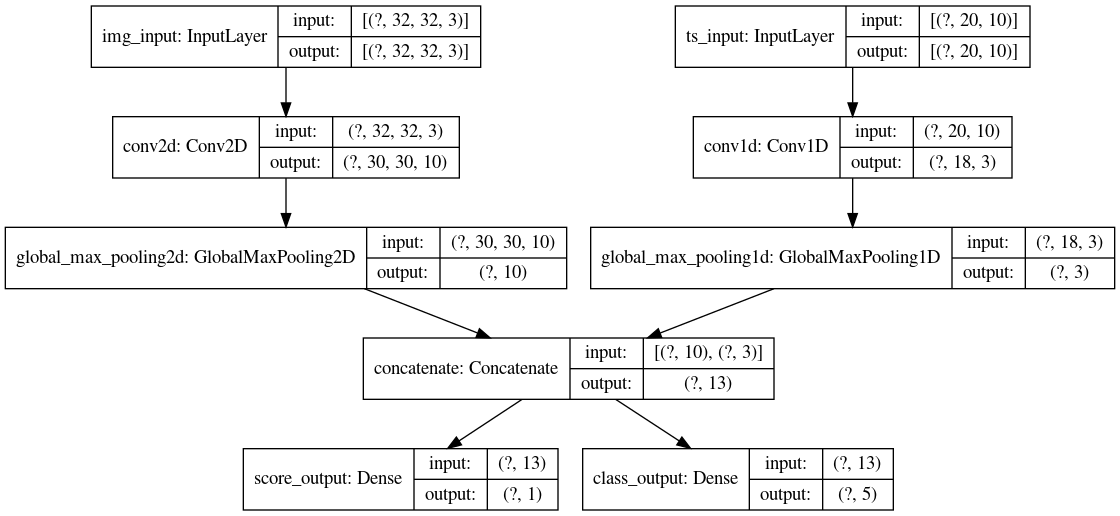

In [6]:
tf.keras.utils.plot_model(my_model3,'multi_input_output_model.png',show_shapes=True)

在编译时，通过将损失函数作为列表传递，我们可以为不同的输出指定不同的损失：

In [7]:
RMS = tf.keras.optimizers.RMSprop(1e-3)
loss = [tf.keras.losses.MeanSquaredError(),
        tf.keras.losses.CategoricalCrossentropy(from_logits=True)]

由于我们为输出层命名，因此我们还可以通过dict指定每个输出的损失和指标：这比上面那个好一些，更清晰不容易搞错 
可以使用以下参数对不同的特定于输出的损失赋予不同的权重（例如，在我们的示例中，我们可能希望通过将某类损失函数赋予更高的权重）
loss_weights 当然也可以选择不计算某些输出的损失，比如有的我只用于预测不用于训练

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(1e-3),
    loss={'class_output':tf.keras.losses.CategoricalCrossentropy(from_logits=True)})

In [8]:
loss = {'score_output':tf.keras.losses.MeanSquaredError(),
        'class_output':tf.keras.losses.CategoricalCrossentropy(from_logits=True)}
met = {'score_output':[tf.keras.metrics.MeanAbsolutePercentageError(),
                      tf.keras.metrics.MeanAbsoluteError()],
       'class_output':[tf.keras.metrics.CategoricalAccuracy()]}#第一个输出我用两个指标，第二个用一个指标
loss_weights = {'score_output':2.,
                'class_output':1.}
my_model3.compile(optimizer=RMS,loss=loss,metrics=met,loss_weights=loss_weights)

In [9]:
img_data = np.random.random_sample(size=(100, 32, 32, 3))
ts_data = np.random.random_sample(size=(100, 20, 10))
score_targets = np.random.random_sample(size=(100, 1))
class_targets = np.random.random_sample(size=(100, 5))

In [10]:
my_model3.fit({'img_input': img_data, 'ts_input': ts_data},
          {'score_output': score_targets, 'class_output': class_targets},
          batch_size=32,
              epochs=3)

Train on 100 samples
Epoch 1/3
100/100 [==============================] - 1s 13ms/sample - loss: 5.1948 - score_output_loss: 0.4973 - class_output_loss: 4.0945 - score_output_mean_absolute_percentage_error: 151.4396 - score_output_mean_absolute_error: 0.7087 - class_output_categorical_accuracy: 0.2100
Epoch 2/3
100/100 [==============================] - 0s 119us/sample - loss: 4.3887 - score_output_loss: 0.2324 - class_output_loss: 3.9364 - score_output_mean_absolute_percentage_error: 72.9379 - score_output_mean_absolute_error: 0.3888 - class_output_categorical_accuracy: 0.2200
Epoch 3/3
100/100 [==============================] - 0s 135us/sample - loss: 4.1530 - score_output_loss: 0.1120 - class_output_loss: 3.7740 - score_output_mean_absolute_percentage_error: 76.0970 - score_output_mean_absolute_error: 0.2618 - class_output_categorical_accuracy: 0.2400
